In [1]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import os
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
 
import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
seed = 2025  # set random seed
batch_size = 64
epochs = 512
learning_rate = 1e-5

In [3]:
np.random.seed(seed)
processor = gd.DataProcessor(processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [4]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [5]:
lep_p = processor.process_part(data.LepP).iloc[:, :4]
lep_p.columns = ["lep_p_" + col.lower() for col in lep_p.columns]
lep_m = processor.process_part(data.LepM).iloc[:, :4]
lep_m.columns = ["lep_m_" + col.lower() for col in lep_m.columns]
w_p = pd.DataFrame(data.Wp["m"])
w_p.columns = ["w_p_" + col.lower() for col in w_p.columns]
w_m = pd.DataFrame(data.Wm["m"])
w_m.columns = ["w_m_" + col.lower() for col in w_m.columns]
met = processor.process_MET(data.MET).iloc[:, 1:3]
met.columns = ["met_px", "met_py"]

# preselction cuts
mask = cut_pre

obs_kin = pd.concat([met, lep_p, lep_m], axis=1)[mask]
print(type(obs_kin))
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3), end="\n\n")

n = len(obs_kin)
wp_pick = np.random.choice(w_p["w_p_m"][mask], size=int(n / 2))
wm_pick = np.random.choice(w_m["w_m_m"][mask], size=n - int(n / 2))
w_pick = np.append(wp_pick, wm_pick)
np.random.shuffle(w_pick)
w_pick = pd.DataFrame({"w": w_pick})

# Sperate the two shell classes
mid = 60 * GEV  # threshold for separating the two classes
sup = 90 * GEV  # upper limit for the suppressed class
w_sup = w_pick["w"] < sup
w_sep = w_pick["w"] >= mid
mask1 = w_sep.to_numpy() & w_sup.to_numpy()
mask2 = ~w_sep.to_numpy()

int_kin_on = pd.DataFrame({"w_on": w_pick["w"][mask1]})
int_kin_off = pd.DataFrame({"w_off": w_pick["w"][mask2]})
print(type(int_kin_on), type(int_kin_off))
print("int_kin shape:", int_kin_on.shape, int_kin_off.shape)
print(int_kin_on.head(3), "\n", int_kin_off.head(3))
# SCALAR_INT_RU_ON = RobustScaler()
# int_kin_on = SCALAR_INT_RU_ON.fit_transform(int_kin_on)
SCALAR_INT_MM_ON = MinMaxScaler()
int_kin_on = SCALAR_INT_MM_ON.fit_transform(int_kin_on)
# SCALAR_INT_RU_OFF = RobustScaler()
# int_kin_off = SCALAR_INT_RU_OFF.fit_transform(int_kin_off)
SCALAR_INT_MM_OFF = MinMaxScaler()
int_kin_off = SCALAR_INT_MM_OFF.fit_transform(int_kin_off)

obs_kin_on = obs_kin[mask1]
obs_kin_off = obs_kin[mask2]
# SCALAR_OBS_RU_ON = RobustScaler()
# obs_kin_on = SCALAR_OBS_RU_ON.fit_transform(obs_kin_on)
SCALAR_OBS_MM_ON = MinMaxScaler()
obs_kin_on = SCALAR_OBS_MM_ON.fit_transform(obs_kin_on)
# SCALAR_OBS_RU_OFF = RobustScaler()
# obs_kin_off = SCALAR_OBS_RU_OFF.fit_transform(obs_kin_off)
SCALAR_OBS_MM_OFF = MinMaxScaler()
obs_kin_off = SCALAR_OBS_MM_OFF.fit_transform(obs_kin_off)

<class 'pandas.core.frame.DataFrame'>
obs_kin shape: (1378510, 10)
       met_px     met_py     lep_p_e   lep_p_px   lep_p_py    lep_p_pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

      lep_m_e   lep_m_px   lep_m_py   lep_m_pz  
7   43.361348  42.407754  -4.632000   7.767462  
9   70.592648  29.001777   1.896990 -64.332027  
10  90.238664 -23.868604  32.986602  80.530680  

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
int_kin shape: (662823, 1) (714177, 1)
           w_on
1  77239.617188
2  79860.078125
3  72860.593750 
           w_off
0  16468.302734
6  51944.984375
9  26099.583984


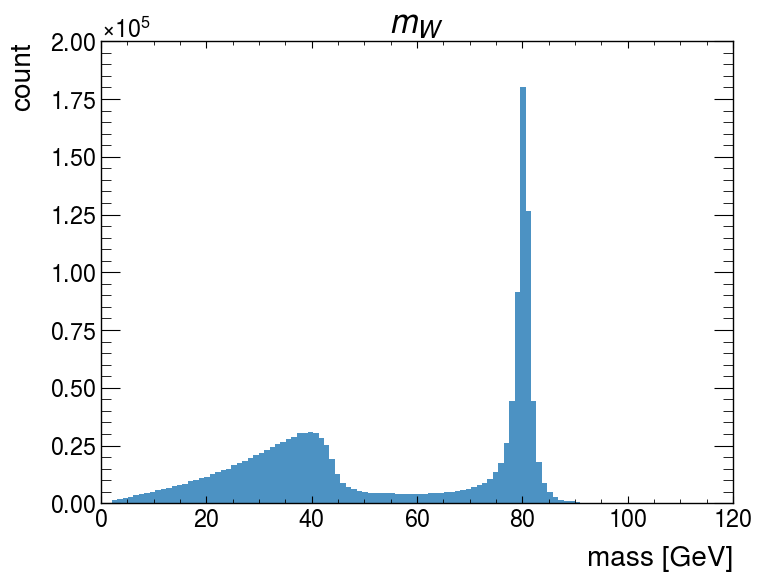

In [6]:
plt.hist(w_pick["w"] / GEV, bins=100, alpha=0.8)
plt.title(r"$m_{W}$")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.show()

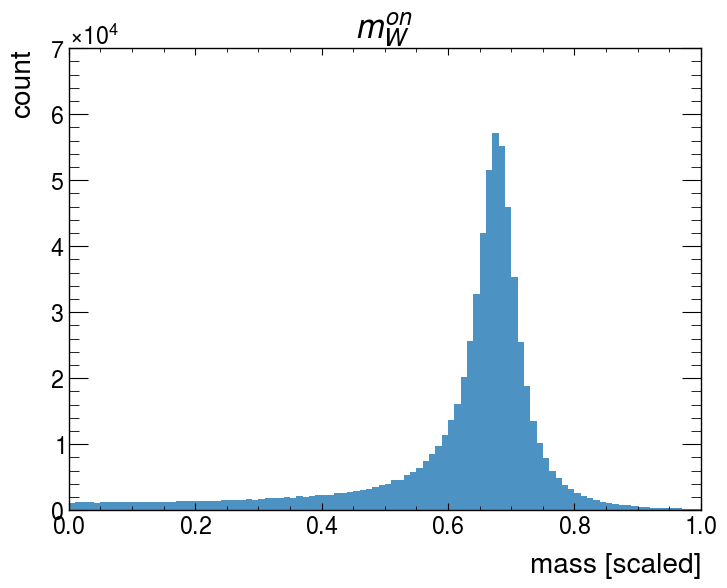

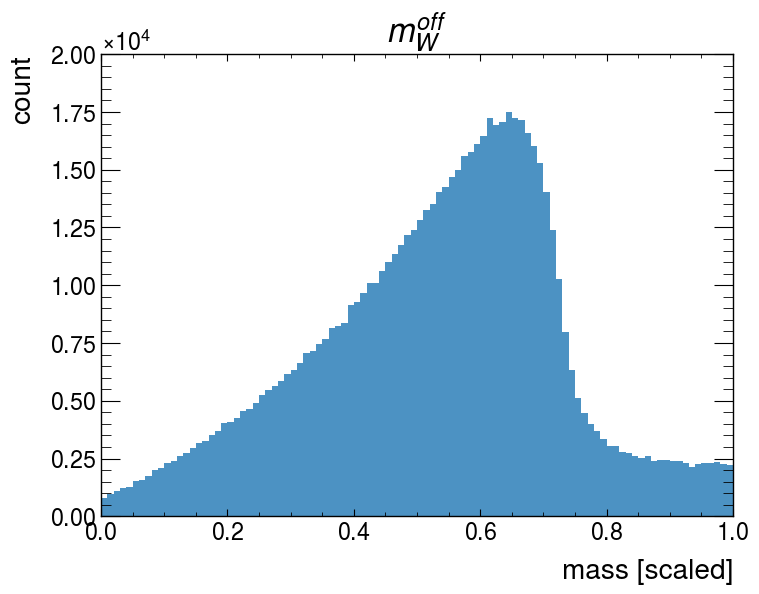

In [7]:
plt.hist(int_kin_on, bins=100, alpha=0.8)
plt.title(r"$m^{on}_{W}$")
plt.xlabel("mass [scaled]")
plt.ylabel("count")
plt.show()

plt.hist(int_kin_off, bins=100, alpha=0.8)
plt.title(r"$m^{off}_{W}$")
plt.xlabel("mass [scaled]")
plt.ylabel("count")
plt.show()

In [8]:
indices_arr = np.arange(int_kin_on.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = obs_kin_on[train_indices]
test_x = obs_kin_on[test_indices]
valid_x = obs_kin_on[valid_indices]
train_y = int_kin_on[train_indices]
test_y = int_kin_on[test_indices]
valid_y = int_kin_on[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (265129, 10);
Validing data shape: (198847, 10);
Testing data shape: (198847, 10).
Y (Observed)
Training data shape: (265129, 1);
Validing data shape: (198847, 1);
Testing data shape: (198847, 1).



In [9]:
# Define a new activation function
def custom_activation(x):
    return x * tf.keras.backend.sigmoid(x)


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=1024, activation="elu", kernel_regularizer="L1L2")(x)
    x = tf.keras.layers.Dense(units=1024, activation="elu", kernel_regularizer="L1L2")(x)
    # x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(units=8, activation="elu")(x)
    x = tf.keras.layers.Dense(units=8, activation="elu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="sigmoid")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [10]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1024)              11264     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 8)                 8200      
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9     

In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512
4143/4143 - 20s - loss: 0.0225 - val_loss: 0.0225 - 20s/epoch - 5ms/step
Epoch 2/512
4143/4143 - 16s - loss: 0.0225 - val_loss: 0.0225 - 16s/epoch - 4ms/step
Epoch 3/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0225 - 16s/epoch - 4ms/step
Epoch 4/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0226 - 16s/epoch - 4ms/step
Epoch 5/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0225 - 16s/epoch - 4ms/step
Epoch 6/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0225 - 16s/epoch - 4ms/step
Epoch 7/512
4143/4143 - 17s - loss: 0.0224 - val_loss: 0.0225 - 17s/epoch - 4ms/step
Epoch 8/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0225 - 16s/epoch - 4ms/step
Epoch 9/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0225 - 16s/epoch - 4ms/step
Epoch 10/512
4143/4143 - 17s - loss: 0.0224 - val_loss: 0.0225 - 17s/epoch - 4ms/step
Epoch 11/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0225 - 16s/epoch - 4ms/step
Epoch 12/512
4143/4143 - 16s - loss: 0.0224 - val_loss: 0.0225 

In [12]:
# save model
model.save("DNN_on-shell_w_m.h5", save_format="h5", overwrite=True)
# predict
pred_y = model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6214/6214 [==============================] - 8s 1ms/step


In [13]:
print(
    f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}, min: {np.min(sig_truth[:,0]):.3f}, max: {np.max(sig_truth[:,0]):.3f}"
)

Truth mean: 0.620, std: 0.150, min: 0.000, max: 1.000


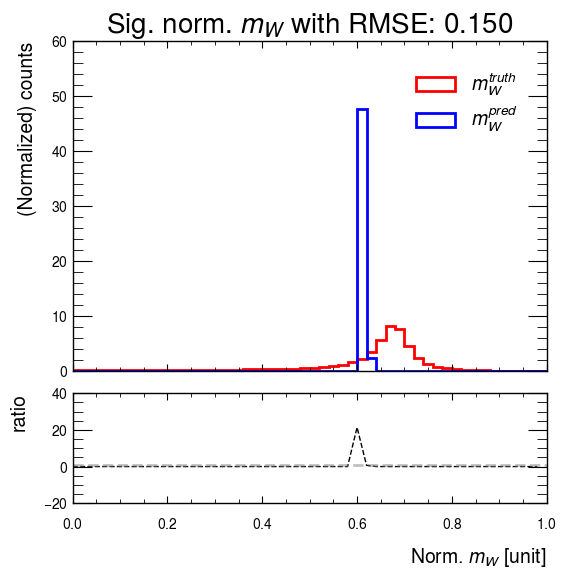

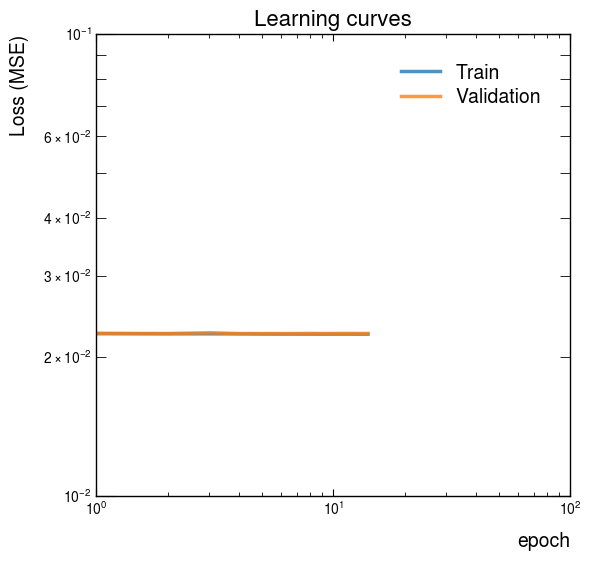

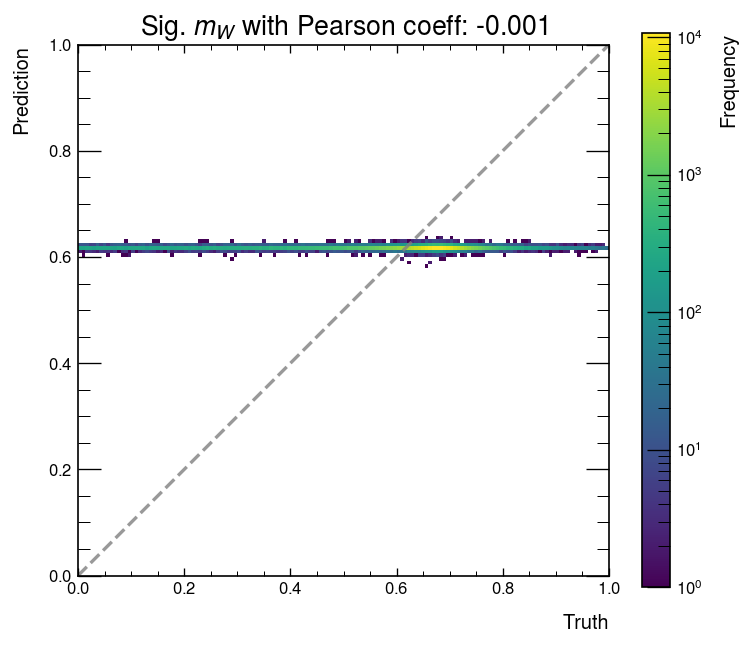

In [14]:
range = [0, 1]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$m^{truth}_{W}$", r"$m^{pred}_{W}$"],
    r"Sig. norm. $m_{W}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    range=range,
    xlabel=r"Norm. $m_{W}$ [unit]",
)

# plot.plot_hist(
#     [sig_truth[:, 1], sig_pred[:, 1]],
#     [r"$m^{truth}_{W^-}$", r"$m^{pred}_{W^-}$"],
#     r"Sig. norm. $m_{W^-}$"
#     + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
#     range=range,
#     xlabel=r"Norm. $m_{W^-}$ [unit]",
# )

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Sig. $m_{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)
# plot.plot_2d_histogram(
#     sig_truth[:, 1],
#     sig_pred[:, 1],
#     r"Sig. $m_{W^-}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,1], sig_pred[:,1])[0]:.3f}",
#     range=range,
# )

In [15]:
# # Background
# processor = gd.DataProcessor(sampling=sampling, processor=10)
# path = "/root/data/truth/background/*npz"
# processor.load_files(path)
# data = gd.Data(*processor.files)
# # print(dir(data))